## Bollinger Bands

In [17]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import backtrader as bt
import matplotlib 

In [18]:
class BollingerBands(bt.Strategy):
    params = (('period', 20),('stddev', 2.8),)
    
    
    def log(self, text, dt = None):
        dt = dt or self.datas[0].datetime.date(0)
        print("%s %s" %(dt.isoformat(), text))
        
    def __init__(self):
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.bband = bt.indicators.BollingerBands(self.datas[0], period=self.params.period, devfactor=self.params.stddev)
    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'Buy Executed, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            elif order.issell():
                self.log('Sell Executed, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))
            self.bar_executed = len(self)
        elif order.status in [order.Rejected]:
            self.log('Order Rejected')
        elif order.status in [order.Canceled]:
            self.log('Order Canceled')
        elif order.status in [order.Margin]:
            self.log('Order Margin')
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('Operation Profit, GROSS %.2f, NET %.2f' %(trade.pnl, trade.pnlcomm))
    
    def next(self):
        if self.order:
            return
        if not self.position:
            if self.data.close < self.bband.lines.bot:
                self.log('Buy Create, %.2f' % self.data.close[0])
                self.order = self.buy()
            elif self.data.close > self.bband.lines.top:
                self.log('Sell Create, %.2f' % self.data.close[0])
                self.order = self.sell()
        else:
            if self.position.size>0 and self.data.close >= self.bband.lines.mid:
                self.log('Sell Create, %.2f' % self.data.close[0])
                self.order = self.close()
            elif self.position.size<0 and self.data.close <= self.bband.lines.mid:
                self.log('Buy Create, %.2f' % self.data.close[0])
                self.order = self.close()

In [19]:
#Instantiate Cerebro engine
cerebro = bt.Cerebro()

In [20]:
#Add data feed to Cerebro
data = bt.feeds.YahooFinanceCSVData(
    dataname='../data/BAJFINANCE.NS.csv',
    fromdate=datetime.datetime(2018, 1,1),
    todate=datetime.datetime(2019, 12, 31))
cerebro.adddata(data)

In [21]:
#Add strategy to Cerebro
cerebro.addstrategy(BollingerBands)

0

In [22]:
# Set our desired cash start
cerebro.broker.setcash(100000.0)
# Set the commission
cerebro.broker.setcommission(commission=0.01)

In [23]:
# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00


In [24]:
#Run Cerebro Engine
cerebro.run()

2018-05-17 Sell Create, 2054.62
2018-05-18 Sell Executed, Price: 2058.00, Cost: -2058.00, Comm 20.58
2018-09-03 Buy Create, 2713.05
2018-09-04 Buy Executed, Price: 2713.00, Cost: -2058.00, Comm 27.13
2018-09-04 Operation Profit, GROSS -655.00, NET -702.71
2019-05-17 Sell Create, 3287.77
2019-05-20 Sell Executed, Price: 3376.31, Cost: -3376.31, Comm 33.76
2019-06-17 Buy Create, 3452.50
2019-06-18 Buy Executed, Price: 3459.97, Cost: -3376.31, Comm 34.60
2019-06-18 Operation Profit, GROSS -83.66, NET -152.02
2019-09-20 Sell Create, 3693.71
2019-09-23 Sell Executed, Price: 3811.24, Cost: -3811.24, Comm 38.11
2019-10-25 Buy Create, 3978.11
2019-10-29 Buy Executed, Price: 3980.85, Cost: -3811.24, Comm 39.81
2019-10-29 Operation Profit, GROSS -169.61, NET -247.53
2019-12-02 Buy Create, 3941.39
2019-12-03 Buy Executed, Price: 3930.92, Cost: 3930.92, Comm 39.31
2019-12-13 Sell Create, 4062.61
2019-12-16 Sell Executed, Price: 4078.58, Cost: 3930.92, Comm 40.79
2019-12-16 Operation Profit, GROSS 

In [25]:
# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())


Final Portfolio Value: 98965.30


<IPython.core.display.Javascript object>


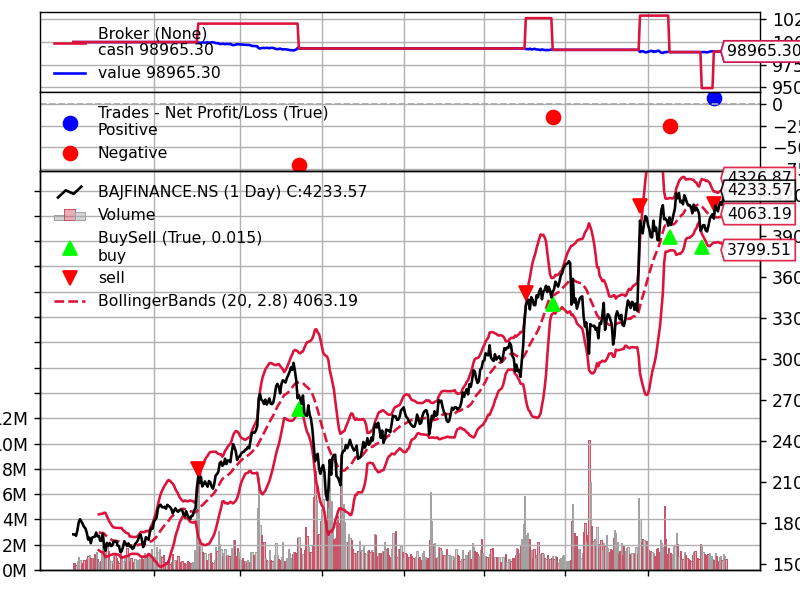

[[<Figure size 640x480 with 4 Axes>]]

In [26]:
cerebro.plot()